In [1]:
# sys, file and nav packages:
import datetime as dt
import json

# math packages:
import pandas as pd
import numpy as np
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

start_date = '2020-03-01'
end_date ='2021-05-31'

a_qty = 20

a_fail_rate = .1

unit_label = 'p/100m'
reporting_unit = 100

# name of the output folder:
name_of_project = 'dist_map'

# get your data:
df= pd.read_csv('checked_sdata_eos_2020_21.csv')

# with open("river_basins.json", "r") as infile:
#     river_bassins = json.load(infile)

dfBeaches = pd.read_csv("beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("codes_with_group_names_2015.csv")
dfDims = pd.read_csv("corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)
        
dfCodes.set_index("code", inplace=True)

# code description map
code_d_map = dfCodes.description

# code material map
code_m_map = dfCodes.material

# Changes in Spearmans $\rho$ as buffer size changes

Spearmans ranked test for correlation is being used to test the association of the number of objects found on the beach with the type of land use within a defined radius of the location where the objects were found.

The national survey on land use is the source for the classification of land use types. For every 100m² of the national territory there is an attributed land use classification based on the analysis of aerial images.

In [2]:
# this is the aggregated survey data that is being used
fd = df.copy()
fd['loc_dates'] = list(zip(fd.location, fd["date"]))
fd['date'] = pd.to_datetime(fd["date"])

# get rid of microplastics
mcr = df[df.groupname == "micro plastics (< 5mm)"].code.unique()
micro = ["G112", *mcr]
fd = fd[~fd.code.isin(micro)].copy()

# there was a data entry error
fd.code = fd.code.replace('G207', 'G208')

# the location data for the surveys
dfb = dfBeaches.loc[fd.location.unique()].copy()

# manager dict for key statisitics and
# common aggregations
t = {}

t.update({"nlakes":fd[fd.w_t == 'l'].water_name_slug.nunique(),
          "nrivers":fd[fd.w_t == 'r'].water_name_slug.unique(),
         "ncodes":fd.code.nunique(),
         "quantity":fd.quantity.sum()}
        )

In [3]:
# the landuse descriptors are integers, key them to a readable descriptor
# the source is https://www.bfs.admin.ch/bfs/fr/home/statistiques/espace-environnement/enquetes/area.html
# using column AS1827
label_keys = {
    1:"industrial",
    2:"residential",
    3:"government",
    4:"agg_buildings",
    5:"unk_building",
    6:"roads",
    7:"railways",
    8:"airports",
    9:"special",
    10:"recreational",
    11:"orchards",
    12:"vineyards",
    13:"horticulture",
    14:"arable",
    15:"meadows",
    16:"farmpastures",
    17:"alpinemeadows",
    18:"aplinepasteurs",
    19:"closed_forest",
    20:"open_forest",
    21:"brush_forest",
    22:"woods",
    23:"lakes",
    24:"rivers",
    25:"unproductive",
    26:"bareland",
    27:"glaciers"
}

key_labels = {v:k for k,v in label_keys.items()}

# group the land use into functional groups
# land use categories that are to be tested alone
# should be in their own group
group_parts = {'buildings':[2,3,4,5,9],
               'ind':[1],              
               'trans':[6,7,8],
               'recreation':[10],
               'agg':[11, 12, 13, 14, 15, 16, 18],
               'woods':[17,19,20,21,22],
               'water':[23,24],
               'unproductive':[25,26,27]
              }

# make column names based on the key values:
as_1827_part ={k:F"part_{v}" for k,v in label_keys.items()}

# this is the final value that is being tested against
# the survey results. Map survey results to these 
# aggregated luse features
som_cols = ['% to buildings',
            '% to ind',
            '% to trans',
            '% to recreation',
            '% to agg',
            '% to woods',
            '% to water',
            '% to unproductive',
                
]

key_labels.update({'luse_total':'total','water_value':'water_value', 'adjusted_land_use':'adjusted_land_use'})
cols_lu = ['recreational', 'farmpastures', 'closed_forest', 'rivers',
       'residential', 'roads', 'unproductive', 'industrial', 'railways',
       'woods', 'arable', 'special', 'government', 'unk_building', 'lakes',
       'meadows', 'horticulture', 'orchards', 'agg_buildings', 'bareland',
       'open_forest', 'vineyards', 'airports', 'brush_forest',
       'aplinepasteurs', 'alpinemeadows', 'glaciers','luse_total',
       'water_value', 'adjusted_land_use']

new_descriptions = { 'Industrial pellets (nurdles)': 'Pellets',
                    'Glass drink bottles, pieces': 'Glass bottles and pieces', 
                    'Food wrappers; candy, snacks': 'Food wrappers', 
                    'Food wrappers; candy, snacks': 'Food wrappers', 
                    'Foam packaging/insulation/polyurethane': 'Foam packaging for insulation', 
                    'Packaging films nonfood or unknown': 'Packaging films (not food-related)', 
                    'Lids unidentified': 'Other lids', 
                    'Tobacco; plastic packaging, containers': 'Plastic packaging for tobacco', 
                    'Fireworks paper tubes and fragments': 'Fireworks (paper parts)', 
                    'Diapers - wipes': 'Diapers and wipes', 
                    'Foamed items & pieces (non packaging/insulation) foamed sponge material': 'Foam items and pieces (not insulation)', 
                    'Labels, bar codes': 'Labels and bar codes', 
                    'Sanitary pads /panty liners/tampons and applicators': 'Sanitary pads, tampons and applicators', 
                    'Pellet mass from injection molding': 'Pellet mass', 
                    'Bags; plastic shopping/carrier/grocery and pieces': 'Plastic bags and pieces', 
                    'Lids for chemicals, detergents (non-food)': 'Lids for chemicals and detergents', 
                    'Coverings; plastic packaging, sheeting for protecting large cargo items': 'Plastic sheeting for large cargo items', 
                    'Construction material; bricks, pipes, cement': 'Construction materials (bricks, pipes, cement)', 
                    'Fireworks; rocket caps, exploded parts & packaging': 'Fireworks (rocket caps, exploded parts and packaging)', 
                    'Foamed EVA (flexible plastic) for crafts & watersports': 'Foamed EVA', 
                    'Metal bottle caps, lids & pull tabs from cans': 'Metal bottle caps, lids and pull tabs from cans', 
                    'Lid/cap rings from plastic bottles/containers': 'Lids and cap rings from plastic bottles', 
                    'Tissue, toilet paper, napkins, paper towels': 'Tissues, toilet paper and paper towels', 
                    'Cotton bud/swab sticks': 'Cotton buds and swab sticks', 
                    'Foil wrappers, aluminum foil': 'Aluminum foil', 
                    'Clothing, towels & rags': 'Clothing and rags', 
                    'Food containers single use foamed or plastic': 'Plastic food containers', 
                    'Plastic fragments angular <5mm': 'Angular plastic fragments (< 0.5 cm)', 
                    'Plastic fragments rounded <5mm': 'Round plastic fragments (< 0.5 cm)', 
                    'Foamed  plastic <5mm': 'Foam plastic (< 0.5 cm)', 
                    'Styrofoam < 5mm': 'Styrofoam fragments (< 0.5 cm)', 
                    'Glass or ceramic fragments > 2.5 cm': 'Glass and ceramic fragments (> 2.5 cm)',
                   }
to_replace = new_descriptions.keys()

# define functions to map luse data to survey locations
def aggregate_buffer_data(data, cols, bufferdata, label_keys, **kwargs):
    """Maps values of <bufferdata> to <data> using the values in data.index.
    Each location is assigined a value from the <buffer data>. If the
    location does not have any corresponding buffer data it is assigned 0.
    
    :param data: A data frame with the locations
        of interest as the index.
    :type data: pandas.core.frame.DataFrame
    :param cols: A list of the new column names from
        the buffer data
    :type cols: list, array of column names
    :param bufferdata: A dataframe with two columns
        one for the landuse name and the other for the
        cumulative sum of that feature from the buffer
    :type bufferdata: pandas.core.frame.DataFrame
    :param label_keys: A mapping of numerical categories to labels
    :type label_keys: dict
    :return: The orginal data frame with the new columns added
    """
    
    # make empty columns for the measured land use features
    for acol in cols:
        data[acol]= 0

    # assign the land use value to each location
    for beach in data.index:
        # for each category of land use
        for label in list(label_keys):
            # assign a value
            try:
                new_data = bufferdata[(bufferdata.location == beach)&(bufferdata.label == label)].AS18_27.values[0]
            except:
                new_data = 0
            # assign that value to the location data
            data.loc[beach, label] = new_data
    
    return data

# account for the area attributed to water by removing the
# the value of water features from land use total
def adjusted_land_use(data, col_keys):
    """Account for the area attributed to water by removing the
    the value of water features from land use total.
    
    :param data: A data frame with the column luse_total
    :type data: pandas.core.frame.DataFrame
    :param col_keys: The column names of all non water land
        use columns.
    :type cols: list, array of column names
    :return: The orginal data frame with the new columns added
    """
    # total land use
    data['luse_total'] = data.loc[:,list(col_keys)].sum(axis=1)

    # amount attributed to water
    data['water_value'] = data.loc[:, ['lakes','rivers']].sum(axis=1)

    # the adjsuted land use
    # remove the water value from land use stats
    data['adjusted_land_use'] = data.luse_total - data.water_value
    
    return data

# determine the ratio of each landuse feature to the adjusted total for each buffer
def account_for_adj_luse(data, col_keys):
    """Uses the adjusted land use total to determine
    the % total for each feature.
    
    :param data: A data frame with the defined land use columns
    :type data: pandas.core.frame.DataFrame
    :param col_keys: The column names of all non water land
        use columns.
    :type cols: list, array of column names
    :return: The data frame with the part of total of the
        adjsuted land use for each AS1827 category
    """
    for label in list(col_keys.values()):
        a_label = F"part_{label}"
        data[a_label] = data[label]/data['adjusted_land_use']
    return data

# merge survey results to land use stats
def assign_luse_stat_to_survey_results(sdata, luse_data, som_cols):
    for a_beach in sdata.location.unique():
        for element in som_cols:
            sdata.loc[sdata.location == a_beach, element] = luse_data.loc[a_beach, element]
    return sdata

# apply method and check results
def check_hypothesis(this_data, some_codes, variables, method):
    myresults = {}
    for i,code in enumerate(some_codes):
        data = this_data[this_data.code == code]
        code_results ={code:{}}
        for j, n in enumerate(variables):
            corr, a_p = method(data[n], data[unit_label])
            if a_p <= 0.05:
                code_results[code].update({n:corr})
            else:
                code_results[code].update({n:"X"})
        myresults.update(code_results)
    
    return myresults


def make_col_totals(luse,key_labels, cols, colname='1500', idx='id'):
    x = luse[cols].copy()
    
    x.loc[colname]= x.sum(numeric_only=True, axis=0)
    
    y = x.loc[colname]

    a_tot = pd.DataFrame(index=y.index, data=y)

    a_tot[idx] = a_tot.index.map(lambda x: key_labels[x])
    
    return a_tot 
def agguse_groups(data, group_parts):
    wiw = {}
    for a_group in group_parts.keys():
        part_groups = [data.loc[x] for x in group_parts[a_group]]
        this_g = sum(part_groups)
        wiw.update({a_group:this_g})     
    
    return wiw
def landuse_per_radius(s, key_labels=key_labels, cols_lu=cols_lu, colname=1500, idx="id"):
    b = make_col_totals(s,key_labels, cols_lu, colname=radius, idx='id').set_index("id", drop=True)
    yi= agguse_groups(b, group_parts)
    c = pd.DataFrame.from_dict(yi, orient='index').append(b.loc[['total','water_value', 'adjusted_land_use']])
    return c

# aggregate the groups
def aggregate_the_luse_groups(data, group_parts, as_1827_part):
    """Makes new columns and makes a subtotal column for the
    newly created groups. Aggregates the functional groups defined
    by land use.
        
    :param data: A data frame with the defined land use columns
    :type data: pandas.core.frame.DataFrame
    :param group_parts: A dictionary that maps names to a list
        of column values.
    :type group_parts: dict
    :param as_1827_part: The AS1827 keys to labels dict
    :type as_1827_part: dict
    return: The data frame with the % of total of the
        adjsuted land use for each functional category
    """
    
    for a_group in group_parts.keys():
        part_groups = [as_1827_part[x] for x in group_parts[a_group]]
        new_group = F"% to {a_group}"
        data[new_group] = data.loc[:,part_groups].sum(axis=1)
    
    return data

def aggregate_adjust_account(data, add_these_cols, bufferdata, label_keys={}):
    data = aggregate_buffer_data(data, add_these_cols, bufferdata, list(label_keys.values()))
    data = adjusted_land_use(data, list(label_keys.values()))
    data = account_for_adj_luse(data, label_keys)
    
    return data


def make_bufferdata(a_file_name, a_col="AS18_27", label_keys={}):
    # these are the land use results
    d = pd.read_csv(a_file_name)
    if "slug" in d.columns:
        d.rename(columns={"slug":"location"}, inplace=True)
    else:
        pass

    # the buffer results from qgis
    e = d[[a_col, "location"]].copy()

    # make a df with location slug, landuse label and land use value:
    for a_num in e[a_col].unique():
        e.loc[e[a_col]==a_num, "label"]=label_keys[a_num]

    # counting the number of points inside the buffer for each location and category
    bufferdata = e.groupby(['location','label'], as_index=False)[a_col].count()
    
    return bufferdata


def check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius=1500, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=[]):
    
    # apply the defined groups, adjust and account for
    # the value of the water feature in the total land use
    data = aggregate_adjust_account(data, add_these_cols, bufferdata, label_keys=label_keys)

    # define the % of total land use for each group
    s = aggregate_the_luse_groups(data, group_parts, as_1827_part)

    # tag each result with the radius
    s['dist'] = radius
    
    # assign the land use to the survey result
    fd_luse = assign_luse_stat_to_survey_results(fd, s,som_cols) 
    this_data = fd_luse[[unit_label,*som_cols, 'code']]
    
    # check rho for each value
    myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    a = pd.DataFrame.from_dict(myresults, orient='index')
    a.replace('X', 0, inplace=True)
    a["dist"] = radius
    
    return a, s

def check_condition(x, conditions, i):
    
    if list(set(x)&set(conditions[i])):
        data = conditions[i][0]        
    elif i == 0 and not list(set(x)&set(conditions[i])):
        data = "Others"    
    else:
        data = check_condition(x, conditions, i-1)
    return data

### Definition of abundant_codes

Currently the \<abundant_codes\> are defined as any object that had a value greater than \<a_qty\> at any survey. That is one possible way to find codes that may have an association. There are others.

In [4]:
# the current definition of abundant codes
abundant_codes = fd[fd.quantity > a_qty].code.unique()

# order of code index
code_totals = fd[fd.code.isin(abundant_codes)].groupby("code").quantity.sum()
code_order = code_totals.sort_values(ascending=False).index

t.update({"qMostCommon":fd[fd.code.isin(abundant_codes)].quantity.sum()})

# the fail rate is another way to differentiate
# define abundant codes by fail rate
agg_this = {"quantity":"sum", "p/100m":"sum", "fail":"sum"}

c_totals = fd.groupby("code", as_index=False).agg(agg_this)
c_totals["fr"] = c_totals["fail"]/fd.loc_date.nunique()

fail_codes = c_totals[c_totals.fr > a_fail_rate].code.unique()

# either way the object description needs to be added to the survey results:
for code in fd.code.unique():
    fd.loc[fd.code == code, "description"] = code_d_map.loc[code]

# the descriptions were corrected of typos
for replaceme in to_replace:
    fd.loc[fd.description == replaceme, "description"] = new_descriptions[replaceme]

## 1500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [5]:
# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# the bufferdata for this radius
bufferdata = make_bufferdata("noas04_27.csv", a_col="AS18_27", label_keys=label_keys)

radius = 1500

# the functional land use groups:
these_groups = list(group_parts.keys())



add_these_cols = bufferdata.label.unique()

a1500, s = check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=abundant_codes)


a1500["quantity"] = a1500.index.map(lambda x: code_totals.loc[x])
a1500["material"] = a1500.index.map(lambda x: code_m_map.loc[x])
a1500.sort_values(by="quantity", inplace=True)

# use intersects

water_int = fd[fd.code.isin(abundant_codes)][["loc_date", "code", "pcs_m", "quantity", "intersects"]]
for each_code in abundant_codes:
    new_data = water_int[water_int.code == each_code][["intersects", "pcs_m"]]
    c, p = stats.spearmanr(new_data.pcs_m.values, new_data.intersects.values)
    if p <= 0.05:
        a1500.loc[each_code, "intersects"] = c
    else:
        a1500.loc[each_code, "intersects"] = 0

totals=[]
lnd_u = []
totals.append(landuse_per_radius(s))
lnd_u.append(s)

a1500["description"] = a1500.index.map(lambda x: code_d_map.loc[x])

col_order = [a1500.columns[-1], *a1500.columns[:-1]]
a1500 = a1500.reindex(code_order)
a1500[col_order].head()

,description,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,quantity,material,intersects
code,,,,,,,,,,,,,
G27,Cigarette filters,0.329882,0.000000,0.345363,0.297737,-0.283219,-0.179103,0.168776,-0.282892,1500,8485,Plastic,0.000000
Gfrags,Fragmented plastics,0.117534,0.000000,0.117785,0.201862,0.000000,0.000000,0.110850,0.000000,1500,7400,Plastic,0.161388
Gfoam,Expanded polystyrene,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125314,-0.100961,1500,5563,Plastic,0.269132
G30,"Food wrappers; candy, snacks",0.248042,0.149508,0.279077,0.290929,-0.155087,-0.125135,0.106595,-0.109077,1500,3325,Plastic,0.000000
G67,Industrial sheeting,-0.102809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500,2534,Plastic,0.239948


### Results Spearmans Rho

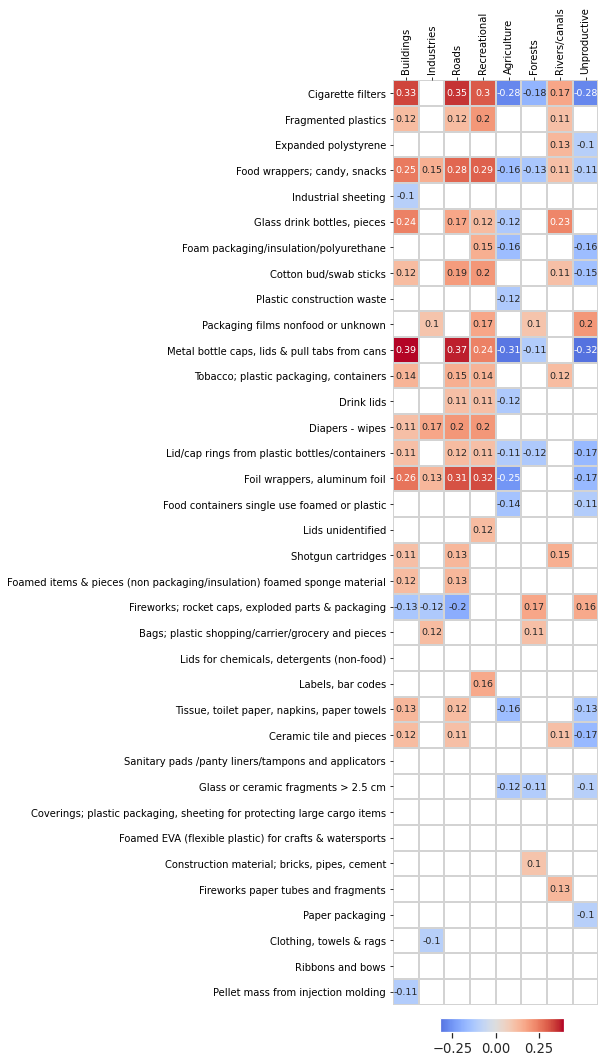

In [6]:
# [Correlation matrix plot]
new_column_names = {
    "% to buildings":"Buildings",
    "% to ind":"Industries",
    "% to trans":"Roads",
    "% to recreation":"Recreational",
    "% to agg":"Agriculture",
    "% to woods":"Forests",
    "% to water":"Rivers/canals",
    "% to unproductive":"Unproductive"
}
# a1500.set_index('description', inplace=True)
a1500.rename(columns=new_column_names, inplace=True)
use_these = list(new_column_names.values())
aplot = a1500[[*use_these, "description"]].round(2)
aplot.set_index("description", inplace=True, drop=True)
fig, ax= plt.subplots(figsize=(17,17))
sns.set(font_scale=1.2)

kwargs = dict(annot=True, fmt="g", cmap='coolwarm',
              annot_kws={"size":9.5},center =0, mask=aplot==0,
              square = True, linewidths=0.1,linecolor="lightgrey",
              cbar = False)

ax = sns.heatmap(aplot, ax=ax, **kwargs)

ax.set_ylabel('')
ax.yaxis.tick_left()

ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')
ax.set_xticklabels(use_these,rotation=90)
       
ax_divider = make_axes_locatable(ax)
axins = inset_axes(ax,
                   width="60%",  # width = 5% of parent_bbox width
                   height="1.5%",  # height : 50%
                   loc='lower center',
                   bbox_to_anchor=(0.03, -0.03, 1, 1),
                   bbox_transform=ax.transAxes, 
                   borderpad=0
                   )

fig.colorbar(ax.get_children()[0], cax = axins, orientation = 'horizontal', extendfrac='auto')
# plt.savefig('output/corr_matrix_1500.png', bbox_inches='tight')

plt.show()

### Covariance of explanatory variables

In [7]:
rho = aplot.corr(method='spearman')
pval = aplot.corr(method=lambda x, y: stats.spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,Buildings,Industries,Roads,Recreational,Agriculture,Forests,Rivers/canals,Unproductive
Buildings,1.0***,0.33**,0.93***,0.62***,-0.48***,-0.5***,0.5***,-0.56***
Industries,0.33**,1.0***,0.39**,0.45***,-0.17,-0.04,0.0,-0.12
Roads,0.93***,0.39**,1.0***,0.67***,-0.46***,-0.53***,0.46***,-0.51***
Recreational,0.62***,0.45***,0.67***,1.0***,-0.43***,-0.35**,0.25,-0.33**
Agriculture,-0.48***,-0.17,-0.46***,-0.43***,1.0***,0.56***,-0.01,0.65***
Forests,-0.5***,-0.04,-0.53***,-0.35**,0.56***,1.0***,-0.24,0.66***
Rivers/canals,0.5***,0.0,0.46***,0.25,-0.01,-0.24,1.0***,-0.18
Unproductive,-0.56***,-0.12,-0.51***,-0.33**,0.65***,0.66***,-0.18,1.0***


#### Sum of the total number of objects with a correlation (positive or negative) collected under the different land use categories

In [8]:
# the cumulative sum of the objects of interest under
# the different landuse categories
cum_sums_objs = [a1500.loc[a1500[x] != 0, "quantity"].sum() for x in use_these]
a_df=pd.DataFrame(index=use_these, data=cum_sums_objs, columns=["total"])
a_df

,total
Buildings,29818
Industries,6032
Roads,27873
Recreational,29645
Agriculture,19889
Forests,14831
Rivers/canals,29710
Unproductive,24654


#### The % total of materials of the objects of interest with respect to the total number of objects collected.

In [9]:
# the % total of materials of the objects of interest
# with respect to the total amount collected
a_total = a1500.quantity.sum()
material_df = pd.DataFrame(a1500.groupby("material").quantity.sum() / a_total).round(3)
material_df

,quantity
material,
Cloth,0.003
Glass,0.063
Metal,0.029
Paper,0.011
Plastic,0.894


#### The % total of the top 36 objects with respect to all objects collected.

In [10]:
# the % total of the 36 objects included in the analysis
# with respect to the total number of objects collected
index = ['ratio of top 36 items over all items:','number of top 36 items:']
data = [f"{(round((t['qMostCommon']/t['quantity'])*100))}%","{:,}".format(round(a_total))]
q_and_p = pd.DataFrame(data=data, index=index, columns=["value"])
q_and_p

,value
ratio of top 36 items over all items:,84%
number of top 36 items:,"42,537"


#### The % total of the top 20 objects with respect to all objects collected

In [11]:
# the % total of the top 20 objects included in the analysis
# with respect to the total number of objects collected
dT20 =a1500.iloc[:20,:]
dT20 = dT20[['description', 'quantity']]

index = ['ratio of top 20 items over all items:','number of top 20 items:']
data = [f"{(round((dT20.quantity.sum()/t['quantity'])*100))}%","{:,}".format(round(dT20.quantity.sum()))]

q_and_p20 = pd.DataFrame(data=data, index=index, columns=["value"])
q_and_p20

,value
ratio of top 20 items over all items:,79%
number of top 20 items:,"39,656"


### The cumulative totals of the top 20 objects, grouped by economic source

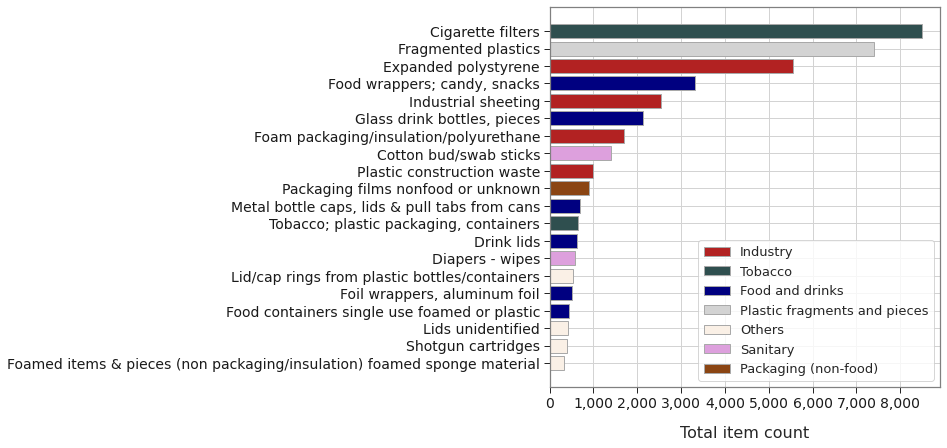

In [12]:
# define the broad categories:
tobaco = ["Tobacco", "Smoking related"]
industry = ['Industry','Construction', 'Industrial', 'Manufacturing']
sanitary = ["Sanitary", "Personal hygiene", "Water treatment"]
packaging = ['Packaging (non-food)','Packaging films nonfood or unknown', 'Paper packaging']
food = ['Food and drinks','Foil wrappers, aluminum foil', 'Food and drinks', 'Food and drink']
fragments = ['Plastic fragments and pieces',
             'Plastic fragments angular <5mm',
             'Styrofoam < 5mm', 
             'Plastic fragments rounded <5mm',
             'Foamed  plastic <5mm',
             'Fragmented plastics']

conditions = [tobaco, industry, sanitary, packaging, food, fragments]

codes = dT20.index    
    
for each_code in codes:
    srcs = dfCodes.loc[each_code][["source", "source_two", "source_three", "description"]]
    
    a = check_condition(srcs.values, conditions, len(conditions)-1)
    dT20.loc[each_code, "Type"] = a

fig, ax = plt.subplots(figsize=(7,7))
colors = {'Industry': 'firebrick', 'Tobacco': 'darkslategrey', 'Food and drinks': 'navy', 'Plastic fragments and pieces':'lightgrey',
         'Others':'linen','Sanitary':'plum','Packaging (non-food)':'saddlebrown'}
N = 3
ind = np.arange(N)
width = 0.6

labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

ax.barh(dT20.description, dT20.quantity, color=[colors[i] for i in dT20.Type], edgecolor='darkgrey')
ax.invert_yaxis()  
ax.set_ylabel('')
ax.set_xticks([0,1000,2000,3000,4000,5000,6000,7000,8000])
ax.set_xticklabels([0,'1,000','2,000','3,000','4,000','5,000','6,000','7,000','8,000'])

ax.set_xlabel('Total item count', fontsize=16, labelpad =15)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelcolor='k', labelsize=14, width=1)
ax.yaxis.grid(color='lightgray')
ax.xaxis.grid(color='lightgray')
ax.set_facecolor('white')

plt.legend(handles, labels, fontsize=13,facecolor='white')
for ha in ax.legend_.legendHandles:
    ha.set_edgecolor("darkgrey")

plt.grid(True)
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')

# plt.savefig('C:/Users/schre086/figures/land_use_ch/top_20items.png', bbox_inches='tight')

plt.show()

#### Litter items of local origin

Items that have four or more positive associations with a land use category.

In [13]:
cols_corr = ['Buildings', 'Industries', 'Roads', 'Recreational', 'Agriculture',
       'Forests', 'Unproductive']


c_count = a1500.copy()

c_count['corr_count'] = c_count[cols_corr].apply(lambda x: (x!=0).sum(), axis=1)
c_count['pos_corr_count'] = c_count[cols_corr].apply(lambda x: (x>0).sum(), axis=1)



DfLocalItems = c_count[c_count.corr_count >= 4]
local_total = DfLocalItems.quantity.sum()
bullets = [f"* {x}" for x in DfLocalItems.description.unique()]

b = "\n".join(bullets)

a_string = f"""
* The total quantity of items likely to be locally littered:{"{:,}".format(local_total)}
* Proportion of items likely to be of local origin among top items: {int((DfLocalItems.quantity.sum()/t["qMostCommon"])*100)}%

There are {len(DfLocalItems.description.unique())} categories in that group:\n\n {b}'
"""
md(a_string)


* The total quantity of items likely to be locally littered:19,138
* Proportion of items likely to be of local origin among top items: 44%

There are 11 categories in that group:

 * Cigarette filters
* Food wrappers; candy, snacks
* Glass drink bottles, pieces
* Cotton bud/swab sticks
* Packaging films nonfood or unknown
* Metal bottle caps, lids & pull tabs from cans
* Diapers - wipes
* Lid/cap rings from plastic bottles/containers
* Foil wrappers, aluminum foil
* Fireworks; rocket caps, exploded parts & packaging
* Tissue, toilet paper, napkins, paper towels'


#### Ubiquitous items

Items that have three or less positive associations with a land use category and are positively associated with river or stream intersections.

In [14]:
DfUbiItems = c_count[(c_count.corr_count <= 3)&(c_count.intersects > 0)]
ub_total = DfUbiItems.quantity.sum()

bullets = [f"* {x}" for x in DfUbiItems.description.unique()]
b = "\n".join(bullets)

a_string = f"""
* The total quantity of items with less than two positive correlations:{"{:,}".format(ub_total)}
* Proportion of items likely to be locally littered among top items: {int((DfUbiItems.quantity.sum()/t["qMostCommon"])*100)}%

There are {len(DfUbiItems.description.unique())} categories in that group:\n\n {b}'
"""
md(a_string)


* The total quantity of items with less than two positive correlations:19,719
* Proportion of items likely to be locally littered among top items: 46%

There are 9 categories in that group:

 * Fragmented plastics
* Expanded polystyrene
* Industrial sheeting
* Foam packaging/insulation/polyurethane
* Plastic construction waste
* Drink lids
* Food containers single use foamed or plastic
* Lids unidentified
* Pellet mass from injection molding'


#### Other items

Items that have three or less positive associations with a land use category and are NOT positively associated with river or stream intersections.

In [15]:
DfOthers = c_count[(c_count.corr_count <= 3)&(c_count.intersects <= 0)]
other_total = DfOthers.quantity.sum()
bullets = [f"* {x}" for x in DfOthers.description.unique()]

b = "\n".join(bullets)

a_string = f"""
* The total quantity of items with less than two positive correlations: {"{:,}".format(other_total)}
* Proportion of items likely to be locally littered among top items: {int((DfOthers.quantity.sum()/t["qMostCommon"])*100)}%

There are {len(DfOthers.description.unique())} categories in that group:\n\n {b}'
"""
md(a_string)


* The total quantity of items with less than two positive correlations: 3,680
* Proportion of items likely to be locally littered among top items: 8%

There are 16 categories in that group:

 * Tobacco; plastic packaging, containers
* Shotgun cartridges
* Foamed items & pieces (non packaging/insulation) foamed sponge material
* Bags; plastic shopping/carrier/grocery and pieces
* Lids for chemicals, detergents (non-food)
* Labels, bar codes
* Ceramic tile and pieces
* Sanitary pads /panty liners/tampons and applicators
* Glass or ceramic fragments > 2.5 cm
* Coverings; plastic packaging, sheeting for protecting large cargo items
* Foamed EVA (flexible plastic) for crafts & watersports
* Construction material; bricks, pipes, cement
* Fireworks paper tubes and fragments
* Paper packaging
* Clothing, towels & rags
* Ribbons and bows'


In [16]:
# checking if total proportion is 100%

print('total proportion of groups:',((DfOthers.quantity.sum()/t["qMostCommon"])*100) 
      + ((DfUbiItems.quantity.sum()/t["qMostCommon"])*100) 
      + ((DfLocalItems.quantity.sum()/t["qMostCommon"])*100))

total proportion of groups: 100.0


## 2000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [17]:
# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())
radius = 2000

# the functional land use groups:
these_groups = list(group_parts.keys())

# the bufferdata for this radius
bufferdata = make_bufferdata("luse_2000.csv", a_col="AS18_27", label_keys=label_keys)


add_these_cols = bufferdata.label.unique()

a2000, s = check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=abundant_codes)

totals.append(landuse_per_radius(s))
lnd_u.append(s)

a2000["quantity"] = a2000.index.map(lambda x: code_totals.loc[x])
a2000["material"] = a2000.index.map(lambda x: code_m_map.loc[x])
a2000.sort_values(by="quantity", inplace=True)

a2000["description"] = a2000.index.map(lambda x: code_d_map.loc[x])

col_order = [a2000.columns[-1], *a2000.columns[:-1]]
a2000 = a2000.reindex(code_order)
a2000[col_order].sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True).head()

,description,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,quantity,material
code,,,,,,,,,,,,
G904,"Fireworks; rocket caps, exploded parts & packa...",-0.171929,-0.160102,-0.240899,0.0,0.000000,0.187936,0.0,0.153292,2000,301,Plastic
G67,Industrial sheeting,-0.150838,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2000,2534,Plastic
G944,Pellet mass from injection molding,-0.105260,0.000000,0.000000,0.0,0.000000,0.117210,0.0,0.000000,2000,34,Plastic
G208,Glass or ceramic fragments > 2.5 cm,0.000000,0.000000,0.090946,0.0,-0.078248,-0.103626,0.0,-0.099851,2000,175,Glass
G89,Plastic construction waste,0.000000,0.000000,0.000000,0.0,-0.160052,0.000000,0.0,0.000000,2000,992,Plastic


## 2500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [18]:
# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())
radius = 2500

# the functional land use groups:
these_groups = list(group_parts.keys())

# the bufferdata for this radius
bufferdata = make_bufferdata("luse_2500.csv", a_col="AS18_27", label_keys=label_keys)

add_these_cols = bufferdata.label.unique()

a2500, s = check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=abundant_codes)

totals.append(landuse_per_radius(s))
lnd_u.append(s)

a2500["quantity"] = a2500.index.map(lambda x: code_totals.loc[x])
a2500["material"] = a2500.index.map(lambda x: code_m_map.loc[x])
a2500.sort_values(by="quantity", inplace=True)

a2500["description"] = a2500.index.map(lambda x: code_d_map.loc[x])

col_order = [a2500.columns[-1], *a2500.columns[:-1]]
a2500 = a2500.reindex(code_order)
a2500[col_order].sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True).head()

,description,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,quantity,material
code,,,,,,,,,,,,
G904,"Fireworks; rocket caps, exploded parts & packa...",-0.187945,-0.191732,-0.247947,-0.108073,0.000000,0.190079,0.000000,0.142489,2500,301,Plastic
G67,Industrial sheeting,-0.132362,0.000000,0.000000,0.000000,0.000000,0.104952,0.000000,0.000000,2500,2534,Plastic
G208,Glass or ceramic fragments > 2.5 cm,0.000000,0.000000,0.076500,0.000000,-0.083916,-0.103471,0.000000,-0.087234,2500,175,Glass
G137,"Clothing, towels & rags",0.000000,-0.109783,0.000000,0.000000,-0.105207,0.000000,0.000000,0.000000,2500,118,Cloth
G74,Foam packaging/insulation/polyurethane,0.000000,0.000000,0.110780,0.000000,-0.214946,0.000000,0.113653,-0.181772,2500,1702,Plastic


## 3000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [19]:
# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())
radius = 3000

# the functional land use groups:
these_groups = list(group_parts.keys())

# the bufferdata for this radius
bufferdata = make_bufferdata("luse_3000.csv", a_col="AS18_27", label_keys=label_keys)


add_these_cols = bufferdata.label.unique()

a3000, s = check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=abundant_codes)

totals.append(landuse_per_radius(s))
lnd_u.append(s)

a3000["quantity"] = a3000.index.map(lambda x: code_totals.loc[x])
a3000["material"] = a3000.index.map(lambda x: code_m_map.loc[x])
a3000.sort_values(by="quantity", inplace=True)

a3000["description"] = a3000.index.map(lambda x: code_d_map.loc[x])

col_order = [a3000.columns[-1], *a3000.columns[:-1]]
a3000 = a3000.reindex(code_order)
a3000[col_order].sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True).head()

,description,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,quantity,material
code,,,,,,,,,,,,
G904,"Fireworks; rocket caps, exploded parts & packa...",-0.185721,-0.187990,-0.245836,-0.133259,0.000000,0.153336,0.000000,0.154956,3000,301,Plastic
G67,Industrial sheeting,-0.133905,0.000000,-0.119565,-0.110205,0.000000,0.132734,0.000000,0.000000,3000,2534,Plastic
G208,Glass or ceramic fragments > 2.5 cm,0.000000,0.000000,0.000000,0.000000,-0.083354,-0.096389,0.000000,-0.087301,3000,175,Glass
G137,"Clothing, towels & rags",0.000000,-0.118301,0.000000,0.000000,-0.110030,0.000000,0.000000,0.000000,3000,118,Cloth
G89,Plastic construction waste,0.000000,0.000000,0.000000,0.000000,-0.153088,0.000000,0.109524,0.000000,3000,992,Plastic


## 3500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [20]:
# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())
radius = 3500

# the functional land use groups:
these_groups = list(group_parts.keys())

# the bufferdata for this radius
bufferdata = make_bufferdata("luse_3500.csv", a_col="AS18_27", label_keys=label_keys)


add_these_cols = bufferdata.label.unique()

a3500, s = check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=abundant_codes)

totals.append(landuse_per_radius(s))
lnd_u.append(s)

a3500["quantity"] = a3500.index.map(lambda x: code_totals.loc[x])
a3500["material"] = a3500.index.map(lambda x: code_m_map.loc[x])
a3500.sort_values(by="quantity", inplace=True)

# use intersects

water_int = fd[fd.code.isin(abundant_codes)][["loc_date", "code", "pcs_m", "quantity", "intersects"]]
for each_code in abundant_codes:
    new_data = water_int[water_int.code == each_code][["intersects", "pcs_m"]]
    c, p = stats.spearmanr(new_data.pcs_m.values, new_data.intersects.values)
    if p <= 0.05:
        a3500.loc[each_code, "intersects"] = c
    else:
        a3500.loc[each_code, "intersects"] = 0

a3500["description"] = a3500.index.map(lambda x: code_d_map.loc[x])

col_order = [a3500.columns[-1], *a3500.columns[:-1]]
a3500 = a3500.reindex(code_order)
a3500[col_order].sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True).head()

,description,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,quantity,material,intersects
code,,,,,,,,,,,,,
G904,"Fireworks; rocket caps, exploded parts & packa...",-0.187795,-0.165275,-0.241004,-0.121212,0.000000,0.119101,0.000000,0.142215,3500,301,Plastic,0.163059
G67,Industrial sheeting,-0.155885,0.000000,-0.139943,-0.149744,0.000000,0.139882,0.000000,0.000000,3500,2534,Plastic,0.239948
G137,"Clothing, towels & rags",0.000000,-0.112273,0.000000,0.000000,-0.115093,0.000000,0.000000,0.000000,3500,118,Cloth,0.000000
Gfoam,Expanded polystyrene,0.000000,0.000000,0.000000,-0.108144,0.000000,0.000000,0.207754,0.000000,3500,5563,Plastic,0.269132
G74,Foam packaging/insulation/polyurethane,0.000000,0.000000,0.000000,0.000000,-0.230150,0.000000,0.177859,-0.154114,3500,1702,Plastic,0.129817


### Results Spearmans Rho

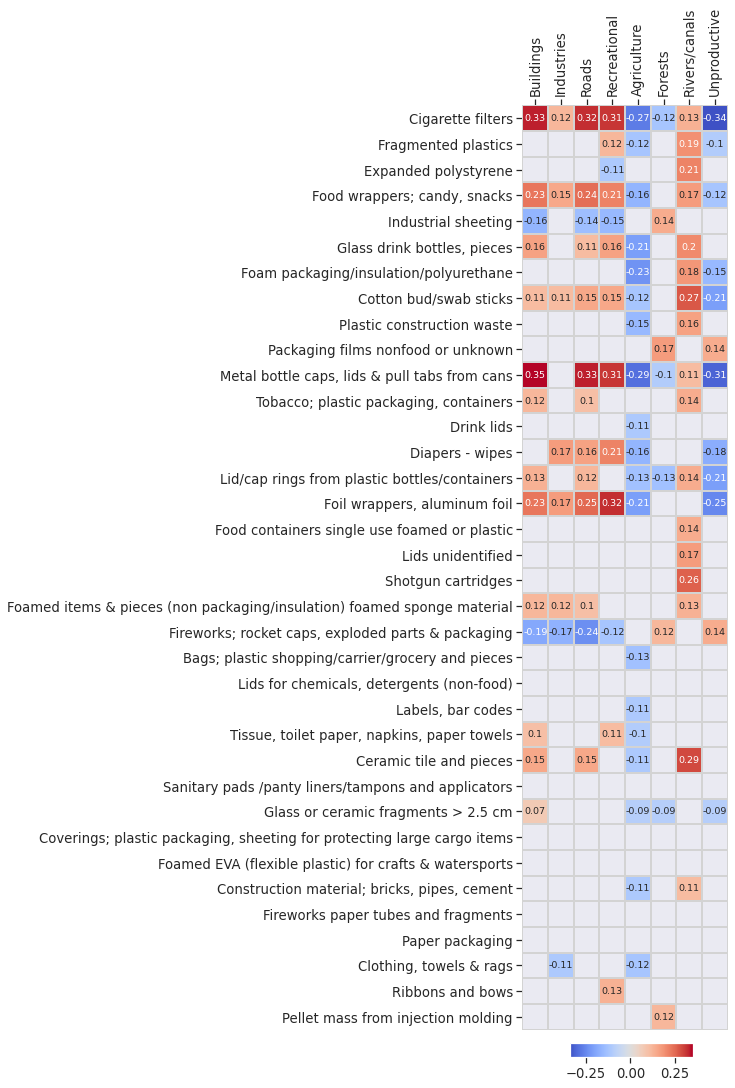

In [21]:
# [Correlation matrix plot]
new_column_names = {
    "% to buildings":"Buildings",
    "% to ind":"Industries",
    "% to trans":"Roads",
    "% to recreation":"Recreational",
    "% to agg":"Agriculture",
    "% to woods":"Forests",
    "% to water":"Rivers/canals",
    "% to unproductive":"Unproductive"
}
# a1500.set_index('description', inplace=True)
a3500.rename(columns=new_column_names, inplace=True)
use_these = list(new_column_names.values())
aplot = a3500[[*use_these, "description"]].round(2)
aplot.set_index("description", inplace=True, drop=True)

fig, ax= plt.subplots(figsize=(17,17))
sns.set(font_scale=1.2)

kwargs = dict(annot=True, fmt="g", cmap='coolwarm',
              annot_kws={"size":9.5},center =0, mask=aplot==0,
              square = True, linewidths=0.1,linecolor="lightgrey",
              cbar = False)

ax = sns.heatmap(aplot, ax = ax, **kwargs)

ax.set_ylabel('')
ax.yaxis.tick_left()

ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')
ax.set_xticklabels(use_these,rotation=90)
       
ax_divider = make_axes_locatable(ax)
axins = inset_axes(ax,
                   width="60%",  # width = 5% of parent_bbox width
                   height="1.5%",  # height : 50%
                   loc='lower center',
                   bbox_to_anchor=(0.03, -0.03, 1, 1),
                   bbox_transform=ax.transAxes, 
                   borderpad=0
                   )

fig.colorbar(ax.get_children()[0], cax = axins, orientation = 'horizontal', extendfrac='auto')
plt.show()

#### Litter items of local origin

Items that have four or more positive associations with a land use category.

In [22]:
cols_corr = ['Buildings', 'Industries', 'Roads', 'Recreational', 'Agriculture',
       'Forests', 'Unproductive']


c_count = a3500.copy()

c_count['corr_count'] = c_count[cols_corr].apply(lambda x: (x!=0).sum(), axis=1)
c_count['pos_corr_count'] = c_count[cols_corr].apply(lambda x: (x>0).sum(), axis=1)



DfLocalItems = c_count[c_count.corr_count >= 3]
local_total = DfLocalItems.quantity.sum()
bullets = [f"* {x}" for x in DfLocalItems.description.unique()]

b = "\n".join(bullets)

a_string = f"""
* The total quantity of items likely to be locally littered:{"{:,}".format(local_total)}
* Proportion of items likely to be of local origin among top items: {int((DfLocalItems.quantity.sum()/t["qMostCommon"])*100)}%

There are {len(DfLocalItems.description.unique())} categories in that group:\n\n {b}'
"""
md(a_string)


* The total quantity of items likely to be locally littered:28,919
* Proportion of items likely to be of local origin among top items: 67%

There are 15 categories in that group:

 * Cigarette filters
* Fragmented plastics
* Food wrappers; candy, snacks
* Industrial sheeting
* Glass drink bottles, pieces
* Cotton bud/swab sticks
* Metal bottle caps, lids & pull tabs from cans
* Diapers - wipes
* Lid/cap rings from plastic bottles/containers
* Foil wrappers, aluminum foil
* Foamed items & pieces (non packaging/insulation) foamed sponge material
* Fireworks; rocket caps, exploded parts & packaging
* Tissue, toilet paper, napkins, paper towels
* Ceramic tile and pieces
* Glass or ceramic fragments > 2.5 cm'


#### Ubiquitous items

Items that have three or less positive associations with a land use category and are positively associated with river or stream intersections.

In [23]:
DfUbiItems = c_count[(c_count.corr_count <= 2)&(c_count.intersects > 0)]
ub_total = DfUbiItems.quantity.sum()

bullets = [f"* {x}" for x in DfUbiItems.description.unique()]
b = "\n".join(bullets)

a_string = f"""
* The total quantity of items with less than two positive correlations:{"{:,}".format(ub_total)}
* Proportion of items likely to be locally littered among top items: {int((DfUbiItems.quantity.sum()/t["qMostCommon"])*100)}%

There are {len(DfUbiItems.description.unique())} categories in that group:\n\n {b}'
"""
md(a_string)


* The total quantity of items with less than two positive correlations:9,785
* Proportion of items likely to be locally littered among top items: 23%

There are 7 categories in that group:

 * Expanded polystyrene
* Foam packaging/insulation/polyurethane
* Plastic construction waste
* Drink lids
* Food containers single use foamed or plastic
* Lids unidentified
* Pellet mass from injection molding'


#### Other items

Items that have three or less positive associations with a land use category and are NOT positively associated with river or stream intersections.

In [24]:
DfOthers = c_count[(c_count.corr_count <= 2)&(c_count.intersects <= 0)]
other_total = DfOthers.quantity.sum()
bullets = [f"* {x}" for x in DfOthers.description.unique()]

b = "\n".join(bullets)

a_string = f"""
* The total quantity of items with less than two positive correlations: {"{:,}".format(other_total)}
* Proportion of items likely to be locally littered among top items: {int((DfOthers.quantity.sum()/t["qMostCommon"])*100)}%

There are {len(DfOthers.description.unique())} categories in that group:\n\n {b}'
"""
md(a_string)


* The total quantity of items with less than two positive correlations: 3,833
* Proportion of items likely to be locally littered among top items: 9%

There are 14 categories in that group:

 * Packaging films nonfood or unknown
* Tobacco; plastic packaging, containers
* Shotgun cartridges
* Bags; plastic shopping/carrier/grocery and pieces
* Lids for chemicals, detergents (non-food)
* Labels, bar codes
* Sanitary pads /panty liners/tampons and applicators
* Coverings; plastic packaging, sheeting for protecting large cargo items
* Foamed EVA (flexible plastic) for crafts & watersports
* Construction material; bricks, pipes, cement
* Fireworks paper tubes and fragments
* Paper packaging
* Clothing, towels & rags
* Ribbons and bows'


In [25]:
# checking if total proportion is 100%

print('total proportion of groups:',((DfOthers.quantity.sum()/t["qMostCommon"])*100) 
      + ((DfUbiItems.quantity.sum()/t["qMostCommon"])*100) 
      + ((DfLocalItems.quantity.sum()/t["qMostCommon"])*100))

total proportion of groups: 100.0


### 4000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [26]:
# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())
radius = 4000

# the functional land use groups:
these_groups = list(group_parts.keys())

# the bufferdata for this radius
bufferdata = make_bufferdata("luse_4000.csv", a_col="AS18_27", label_keys=label_keys)


add_these_cols = bufferdata.label.unique()

a4000, s = check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=abundant_codes)

totals.append(landuse_per_radius(s))
lnd_u.append(s)

a4000["quantity"] = a4000.index.map(lambda x: code_totals.loc[x])
a4000["material"] = a4000.index.map(lambda x: code_m_map.loc[x])
a4000.sort_values(by="quantity", inplace=True)

a4000["description"] = a4000.index.map(lambda x: code_d_map.loc[x])

col_order = [a4000.columns[-1], *a4000.columns[:-1]]
a4000 = a4000.reindex(code_order)
a4000[col_order].sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True).head()

,description,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,quantity,material
code,,,,,,,,,,,,
G904,"Fireworks; rocket caps, exploded parts & packa...",-0.184935,-0.191614,-0.234173,-0.127841,0.000000,0.103456,0.000000,0.128223,4000,301,Plastic
G67,Industrial sheeting,-0.180616,0.000000,-0.173851,-0.158195,0.000000,0.150351,0.000000,0.000000,4000,2534,Plastic
G208,Glass or ceramic fragments > 2.5 cm,0.000000,0.000000,0.000000,0.000000,-0.085554,-0.083381,0.000000,-0.100250,4000,175,Glass
G89,Plastic construction waste,0.000000,-0.112108,0.000000,0.000000,-0.148128,0.000000,0.174754,0.000000,4000,992,Plastic
G137,"Clothing, towels & rags",0.000000,-0.105559,0.000000,0.000000,-0.107798,0.000000,0.000000,0.000000,4000,118,Cloth


### 4500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [27]:
# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())
radius = 4500

# the functional land use groups:
these_groups = list(group_parts.keys())

# the bufferdata for this radius
bufferdata = make_bufferdata("luse_4500.csv", a_col="AS18_27", label_keys=label_keys)

add_these_cols = bufferdata.label.unique()

a4500, s = check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=abundant_codes)

totals.append(landuse_per_radius(s))
lnd_u.append(s)

a4500["quantity"] = a4500.index.map(lambda x: code_totals.loc[x])
a4500["material"] = a4500.index.map(lambda x: code_m_map.loc[x])
a4500.sort_values(by="quantity", inplace=True)

a4500["description"] = a4500.index.map(lambda x: code_d_map.loc[x])

col_order = [a4500.columns[-1], *a4500.columns[:-1]]
a4500 = a4500.reindex(code_order)
a4500[col_order].sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True).head()

,description,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,quantity,material
code,,,,,,,,,,,,
G904,"Fireworks; rocket caps, exploded parts & packa...",-0.203276,-0.208396,-0.238306,-0.146966,0.000000,0.000000,0.000000,0.113832,4500,301,Plastic
G67,Industrial sheeting,-0.194227,0.000000,-0.193314,-0.162510,0.000000,0.153371,0.115901,0.000000,4500,2534,Plastic
Gfoam,Expanded polystyrene,-0.106272,-0.107725,0.000000,0.000000,0.000000,0.000000,0.231096,0.000000,4500,5563,Plastic
G89,Plastic construction waste,0.000000,-0.134463,0.000000,0.000000,-0.137045,0.000000,0.188459,0.000000,4500,992,Plastic
G74,Foam packaging/insulation/polyurethane,0.000000,0.000000,0.000000,0.000000,-0.231010,0.000000,0.223312,-0.122852,4500,1702,Plastic


### 5000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [28]:
# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())
radius = 5000

# the functional land use groups:
these_groups = list(group_parts.keys())

# the bufferdata for this radius
bufferdata = make_bufferdata("luse_5k.csv", a_col="AS18_27", label_keys=label_keys)

add_these_cols = bufferdata.label.unique()

a5000, s = check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=abundant_codes)

totals.append(landuse_per_radius(s))
lnd_u.append(s)

a5000["quantity"] = a5000.index.map(lambda x: code_totals.loc[x])
a5000["material"] = a5000.index.map(lambda x: code_m_map.loc[x])
a5000.sort_values(by="quantity", inplace=True)

a5000["description"] = a5000.index.map(lambda x: code_d_map.loc[x])

col_order = [a5000.columns[-1], *a5000.columns[:-1]]
a5000 = a5000.reindex(code_order)
a5000[col_order].sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True).head()

,description,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,quantity,material
code,,,,,,,,,,,,
G904,"Fireworks; rocket caps, exploded parts & packa...",-0.226256,-0.224103,-0.242135,-0.146554,0.000000,0.000000,0.000000,0.000000,5000,301,Plastic
G67,Industrial sheeting,-0.216371,-0.131283,-0.206335,-0.166623,0.000000,0.147267,0.116064,0.000000,5000,2534,Plastic
Gfoam,Expanded polystyrene,-0.113702,-0.138851,0.000000,-0.107777,-0.102038,0.000000,0.229041,0.000000,5000,5563,Plastic
G944,Pellet mass from injection molding,-0.111164,-0.100864,-0.113282,0.000000,0.000000,0.125616,0.000000,0.107774,5000,34,Plastic
G941,Packaging films nonfood or unknown,-0.107452,0.000000,-0.133638,0.000000,0.000000,0.173375,0.000000,0.112302,5000,894,Plastic


### 10000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [29]:
# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())
radius = 10000

# the functional land use groups:
these_groups = list(group_parts.keys())

# the bufferdata for this radius
bufferdata = make_bufferdata("luse_10k.csv", a_col="AS18_27", label_keys=label_keys)

add_these_cols = bufferdata.label.unique()

a10k, s = check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=abundant_codes)

totals.append(landuse_per_radius(s))
lnd_u.append(s)

a10k["quantity"] = a10k.index.map(lambda x: code_totals.loc[x])
a10k["material"] = a10k.index.map(lambda x: code_m_map.loc[x])
a10k.sort_values(by="quantity", inplace=True)

a10k["description"] = a10k.index.map(lambda x: code_d_map.loc[x])

col_order = [a10k.columns[-1], *a10k.columns[:-1]]
a10k = a10k.reindex(code_order)
a10k[col_order].sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True).head()

,description,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,quantity,material
code,,,,,,,,,,,,
G67,Industrial sheeting,-0.185106,-0.202304,-0.218345,-0.200356,0.000000,0.196207,0.162328,0.148976,10000,2534,Plastic
Gfoam,Expanded polystyrene,-0.140523,-0.214958,-0.147460,-0.195902,0.000000,0.155530,0.219312,0.138448,10000,5563,Plastic
G944,Pellet mass from injection molding,-0.138405,-0.134146,-0.134150,-0.124112,-0.106867,0.111069,0.000000,0.132843,10000,34,Plastic
Gfrags,Fragmented plastics,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.388116,-0.144757,10000,7400,Plastic
G95,Cotton bud/swab sticks,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.435667,-0.128876,10000,1406,Plastic


### Total correlations, total positive correlations and weight for each buffer radius

In [31]:
# the total land use for each buffer zone
t_lu_by_r = pd.concat(totals, axis=1)

# the column names to aggregate
cols = list(new_column_names.values())

# these buffer values need the columns renamed
dfs_oldnames = [a2000, a2500, a3000, a4000, a4500, a5000, a10k]
dfs_newnames = [data.rename(columns=new_column_names) for data in dfs_oldnames]

# combined all the buffer values
dfs = [a1500,dfs_newnames[0], dfs_newnames[1], dfs_newnames[2], a3500, dfs_newnames[3], dfs_newnames[4], dfs_newnames[5], dfs_newnames[6]]

# count the total correlations and positive correlations
for data in dfs:
    data["count"] = data[cols].apply(lambda x: (x!=0).sum(), axis=1)
    data['positive'] = data[cols].apply(lambda x: (x>0).sum(), axis=1)

# convert meters to kilometers for index and printing
con_to_km = [x/1000 for x in t_lu_by_r.columns]

# for each radius get the total and positive count
total_correlation_count = {}
pos_correlations = {}
for i,a_radius in enumerate(con_to_km):
    
    data = dfs[i]
    
    total_count = data["count"].sum()
    pos_count = data["positive"].sum()
    label = a_radius
    total_correlation_count.update({label:total_count})
    pos_correlations.update({label:pos_count})
    
    
# combine the correlation totals per radius in to one df
t_corrs = pd.DataFrame.from_dict(total_correlation_count, orient="index", columns=["# of correlations"])

# add positive correlations
for k,v in pos_correlations.items():
    t_corrs.loc[k, "positive correlations"] = v

# add the weight factor
for i,a_radius in enumerate(con_to_km):
    data=dfs[i]    
    data['weight'] = (data['positive'] * data['quantity'])  
    t_corrs.loc[a_radius, "weight"] = data["weight"].sum()

t_corrs["positive correlations"] = t_corrs["positive correlations"].astype("int")
t_corrs["weight"] = t_corrs["weight"].astype("int")
t_corrs

,# of correlations,positive correlations,weight
1.5,101,65,122289
2.0,102,61,117777
2.5,98,56,102939
3.0,102,59,107789
3.5,104,62,117018
4.0,101,59,114438
4.5,100,59,105397
5.0,104,60,105862
10.0,91,65,120255


## Changes in Spearmans $\rho$ at different buffer sizes

*Spearmans $\rho$ evaluated for expanded foams, fragmented plastics, snack wrappers, production pelltets and cigarettes at different buffer zone radii for % attributed to buildings*

*Table of results*

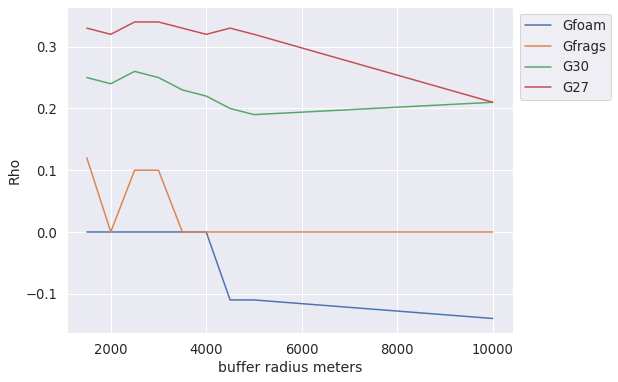

In [32]:
comps = pd.concat(dfs)
comps.reset_index(inplace=True)
comps.rename(columns={'index':'code'}, inplace=True)

fig, ax = plt.subplots(figsize=(8,6))

data = comps[comps.code.isin(['G27', 'Gfrags', 'G30', 'Gfoam', 'G112'])].copy()
aval = "Buildings"
variables=[aval]
data[variables] = data[variables].astype('float').round(2)
data.sort_values(by=aval, inplace=True)

sns.lineplot(data=data, x='dist', y=aval, hue='code')
ax.set_ylabel('Rho', fontsize=14)
ax.set_xlabel('buffer radius meters', fontsize=14)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

## Changes of land use profile for different buffer zones

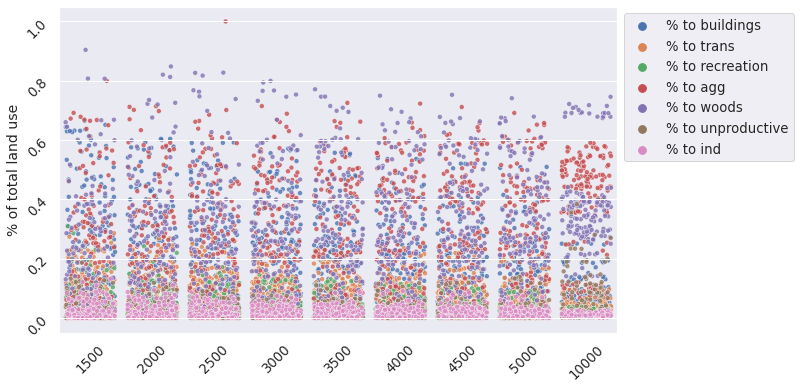

In [42]:
check_dist = ['% to buildings', '% to trans', '% to recreation',  '% to agg', '% to woods', '% to unproductive', '% to ind', 'dist']
ds = [element[check_dist].reset_index() for element in lnd_u]

x=pd.concat(ds)
xlong = pd.melt(x, id_vars=['dist'], value_vars=check_dist[:-1])

fig, ax = plt.subplots(figsize=(10,6))

props = {
 'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    
}
sns.stripplot(data=xlong, x = 'dist', y='value', hue='variable', ax=ax, jitter=.4, zorder=0, alpha=0.8, edgecolor='white', linewidth=.5)
ax.tick_params(labelrotation=45)
ax.set_ylabel("% of total land use", fontsize=14)
ax.set_xlabel("")
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

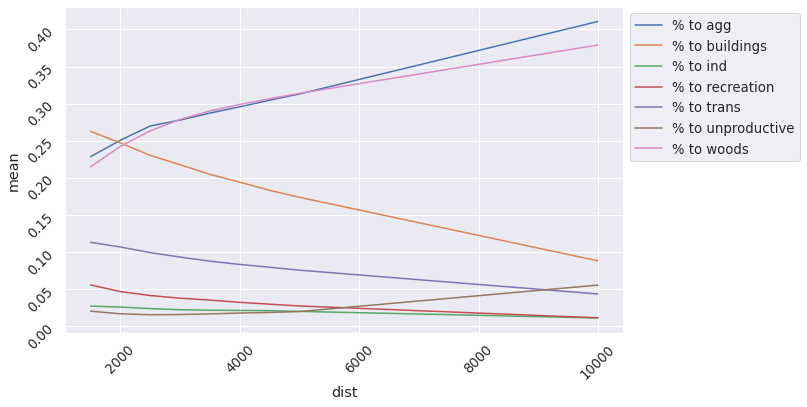

In [41]:
z = xlong.groupby(['variable', 'dist']).value.describe()['mean'].reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=z, x='dist', y='mean', hue='variable')
ax.tick_params(labelrotation=45)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

## Compare the land use rates for each buffer radius

In [49]:
# the row label for the total combined land use
total ='adjusted_land_use'
totaldf = t_lu_by_r.loc[total]

# divide the individual land use categories by the total land-use
# for each radius
landuse = ['agg', 'buildings', 'ind', 'recreation', 'trans', 'unproductive', 'woods']
adf = t_lu_by_r.loc[landuse].copy()
for element in totaldf.index:
    adf[element] =  adf[element]/totaldf.loc[element]

adf=adf.applymap(lambda x:x*100).round(1)
#(lambda x: round(x, 6))
adf

,1500,2000,2500,3000,3500,4000,4500,5000,10000
agg,24.4,25.8,27.2,28.4,29.6,30.7,31.8,32.8,41.1
buildings,28.1,26.5,24.8,23.4,21.9,20.7,19.4,18.3,8.7
ind,3.2,2.9,2.7,2.5,2.4,2.3,2.3,2.2,1.1
recreation,5.9,5.0,4.5,4.1,3.9,3.5,3.2,2.9,1.1
trans,12.4,11.6,10.7,10.0,9.4,8.9,8.4,8.0,4.4
unproductive,2.2,1.8,1.7,1.7,1.8,1.9,2.0,2.2,5.4
woods,24.0,26.4,28.5,29.9,31.0,32.0,32.8,33.6,38.1


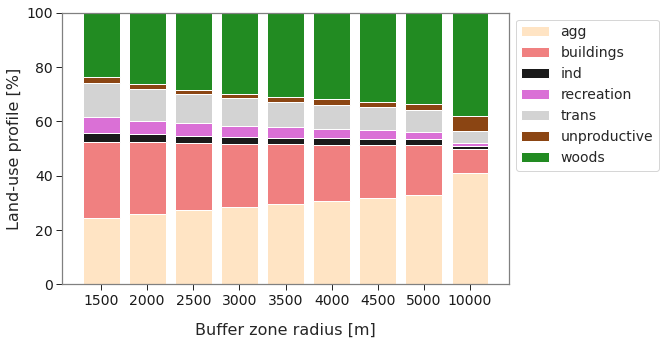

In [63]:
data =adf.values
labels = adf.index
colors = adf.index
xlabels = [str(x) for x in adf.columns]

colors = ['bisque','lightcoral','k','orchid','lightgrey','saddlebrown', 'forestgreen']

bottom = [0]*(len(adf.columns))

width = 0.8      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(8,5))

for i,group in enumerate(data):
    ax.bar(xlabels, group, width, bottom=bottom, label=labels[i], color = colors[i])
    bottom += group


ax.set_ylabel('Land-use profile [%]', fontsize=16)

ax.set_xlabel("Buffer zone radius [m]", labelpad =15, fontsize=16)
ax.set_facecolor('white')

ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')
ax.set_ylim(0,100)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelcolor='k', labelsize=14, width=1)

ax.legend(bbox_to_anchor=(1,1), facecolor = 'white', fontsize=14)

plt.show()

In [ ]:
survey_data = fd_luse_1500.copy()

In [ ]:
survey_data.info()

In [ ]:
# explanatory variables that are being considered
#luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']
luse_exp = ['Buildings [%]','Industrial [%]', 'Recreational [%]', 'Agricultural [%]', 'Forests [%]', 'Unproductive [%]', 'Road network \nlength [km]', 'Rivers/canals [#]']
# columns needed
use_these_cols = ['loc_date' ,
                  'date',
                  '% to buildings',
                  '% to trans',
                  '% to recreation',
                  '% to agg',
                  '% to woods',
                  '% to ind', 
                  '% to unproductive',
                  'population',
                  'water_name_slug',
                  'streets km',
                  'intersects',
                  'groupname',
                  'code'
                 ]

# the land use data was unvailable for these municipalities
no_land_use = ['Walenstadt', 'Weesen', 'Glarus Nord', 'Quarten']

# slice the data by start and end date, remove the locations with no land use data
use_these_args = ((survey_data.date >= start_date)&(survey_data.date <= end_date)&(~survey_data.city.isin(no_land_use)))
survey_data = survey_data[use_these_args].copy()

# format the data and column names
survey_data['date'] = pd.to_datetime(survey_data.date)

# work off a copy
new_som_data = survey_data.copy()

# adjust the fail rate for this aggregation of data
new_som_data['fail'] = True
new_som_data.loc[new_som_data.quantity == 0, 'fail'] = False

In [ ]:
# the survey total for each survey indifferent of object
dfdt = new_som_data.groupby(use_these_cols[:-2], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})


dfdt = new_som_data.groupby(use_these_cols[:-2], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})
dfdt.columns = ['loc_date','date','Built-up environment [%]', '% to tran', 'Recreational [%]', 'Agriculture [%]', 
                'Forests [%]', 'Industries [%]', 'Unproductive land [%]', 'Population', 'water_name_slug', 'Road network \nlength [km]', 'Rivers/canals [#]', 'p/100 m','quantity']

# method to get the ranked correlation of pcs_m to each explanatory variable
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p

sns.set_style("whitegrid")
fig, axs = plt.subplots(1,4, figsize=(9,3), sharey=True)

data = dfdt.copy()

perc_cols = ['Built-up environment [%]','Industries [%]', 'Recreational [%]', 'Agriculture [%]', 'Forests [%]', 'Unproductive land [%]']

data[perc_cols] = data[perc_cols].apply(lambda x:x*100)

cols1 = ['Built-up environment [%]','Industries [%]', 'Recreational [%]', 'Agriculture [%]']
#cols2 = ['Forests [%]', 'Unproductive [%]', 'Road network \nlength [km]', 'Rivers/canals [#]']
for i, n in enumerate(cols1):
    ax=axs[i]
    
    # the ECDF of the land use variable
    the_data = ECDF(data[n].values)
    sns.lineplot(x=the_data.x, y= (the_data.y)*100, ax=ax, color='dodgerblue', label="% of surface area" )
    
    # get the median % of land use for each variable under consideration from the data
    the_median = data[n].median()
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 50, color='red',s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=50, color='red', linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=50, color='red', linewidth=2)
    
    #remove the legend from ax   
    ax.get_legend().remove()
    
    if i == 0:
        ax.set_ylabel("Share of \nsurveys [%]", labelpad = 15)
    else:
        pass
    
    # add the median value from all locations to the ax title
    ax.set_title(F"median: {(round(the_median, 2))}",fontsize=12, loc='left')
    ax.set_xlabel(n, fontsize=14, labelpad=15)

plt.tight_layout()

plt.savefig('C:/Users/schre086/figures/land_use_ch/land_use_1500_A.png', bbox_inches='tight')

plt.show()

In [ ]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,4, figsize=(9,3), sharey=True)

#cols1 = ['Buildings [%]','Industrial [%]', 'Recreational [%]', 'Agricultural [%]']
cols2 = ['Forests [%]', 'Unproductive land [%]', 'Road network \nlength [km]', 'Rivers/canals [#]']
for i, n in enumerate(cols2):
    ax=axs[i]
    
    # the ECDF of the land use variable
    the_data = ECDF(data[n].values)
    sns.lineplot(x=the_data.x, y= (the_data.y)*100, ax=ax, color='dodgerblue', label="% of surface area" )
    
    # get the median % of land use for each variable under consideration from the data
    the_median = data[n].median()
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 50, color='red',s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=50, color='red', linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=50, color='red', linewidth=2)
    
    #remove the legend from ax   
    ax.get_legend().remove()
    
    if i == 0:
        ax.set_ylabel("Share of \nsurveys [%]", labelpad = 15)
    else:
        pass
    
    # add the median value from all locations to the ax title
    ax.set_title(F"median: {(round(the_median, 2))}",fontsize=12, loc='left')
    ax.set_xlabel(n, fontsize=14, labelpad=15)

plt.tight_layout()

plt.savefig('C:/Users/schre086/figures/land_use_ch/land_use_1500_B.png', bbox_inches='tight')

plt.show()

### sort this

In [ ]:
# [Assign types to item categories]

# Df1500.loc[Df1500.source.isin(['Tobacco']) |
#            Df1500.source_two.isin(['Smoking related']),'Type'] ='Tobacco'

# Df1500.loc[Df1500.source.isin(['Industry','Construction', 'Industrial', 'Manufacturing']) |
#            Df1500.source_two.isin(['Industry','Construction', 'Industrial','Manufacturing'])  | 
#            Df1500.source_three.isin(['Industry','Construction', 'Industrial','Manufacturing']),'Type'] ='Industry'

# Df1500.loc[Df1500.source.isin(['Personal hygiene']) |
#            Df1500.source_two.isin(['Water treatment']),'Type'] ='Sanitary'

# Df1500.loc[Df1500.description.isin(['Paper packaging']) |
#            Df1500.description.isin(['Packaging films nonfood or unknown']),'Type'] ='Packaging (non-food)'

# Df1500.loc[Df1500.source_two.isin(['Food and drink']) |
#            Df1500.description.isin(['Foil wrappers, aluminum foil']) |
#            Df1500.source_two.isin(['Food and drinks']),'Type'] ='Food and drinks'

# Df1500.loc[Df1500.description.isin(['Plastic fragments angular <5mm']) |
#            Df1500.description.isin(['Styrofoam < 5mm']) |
#            Df1500.description.isin(['Plastic fragments rounded <5mm']) |
#            Df1500.description.isin(['Foamed  plastic <5mm']) |
#            Df1500.description.isin(['Fragmented plastics']),'Type'] ='Plastic fragments and pieces'
# Df1500.loc[Df1500.Type.isna(), 'Type'] = 'Others'
# Df1500[Df1500.Type == 'Others'].description.unique()

In [ ]:
# DfTypePl = Df1500.groupby(['Type','material']).quantity.sum().reset_index()
# DfTypePl = DfTypePl[DfTypePl.material=='Plastic']
# DfTypePl.columns = ['Type','Plastic','plast_qu']

In [ ]:
# DfType = Df1500.groupby('Type').quantity.sum().reset_index()
# DfType.sort_values(by='quantity',ascending=False,inplace=True)
# DfType['Proportion'] = (DfType.quantity/DfType.quantity.sum())*100
# DfType.Proportion = DfType.Proportion.round(decimals=1)
# DfType.loc[DfType.Type=='Industry','Items'] = 'Expanded polystyrene, Industrial sheeting, Pellets, Foam packaging for insulation, Plastic construction waste, Ceramic tile and pieces, Plastic sheeting for large cargo items, Construction materials (bricks, pipes, cement), Pellet mass'
# DfType.loc[DfType.Type=='Plastic fragments and pieces','Items'] = 'Fragmented plastics' 
# DfType.loc[DfType.Type=='Tobacco','Items'] = 'Cigarette filters; Plastic packaging for tobacco'
# DfType.loc[DfType.Type=='Sanitary','Items'] = 'Sanitary pads, tampons and applicators; Diapers and wipes; Tissues, toilet paper and paper towels, Cotton buds and swab sticks'
# DfType.loc[DfType.Type=='Packaging (non-food)','Items'] = 'Paper packaging, Packaging films (not food-related)'
# DfType.loc[DfType.Type=='Food and drinks','Items'] = 'Food wrappers, Glass bottles and pieces, Metal bottle caps, lids and pull tabs from cans, Drink lids, Aluminum foil, Plastic food containers, Plastic bags and pieces'
# DfType.loc[DfType.Type=='Others','Items'] = 'Lids and cap rings from plastic bottles, Others lids, Shotgun cartridges, Foam items and pieces (not insulation), Fireworks (rocket caps, exploded parts and packaging), Lids for chemicals and detergents, Labels and bar codes, Foamed EVA, Glass and ceramic fragments (> 2.5 cm), Fireworks (paper parts), Clothing and rags, Ribbons and bows, Octopus pots'
# print('Total industrial items over total macrolitter items:', DfType[DfType.Type=='Industry'].quantity.sum()/total_sum )

In [ ]:
# DfTypeAll = pd.merge(DfType, DfTypePl, on = 'Type')

In [ ]:
# DfTypeAll['plast_prop'] = ((DfTypeAll.plast_qu)/(DfTypeAll.quantity)*100).round(1)
# DfTypeAll

In [ ]:
# DfType.sort_values(by='quantity',ascending=False)
# DfType.to_csv('C:/Users/schre086/datasets/Switzerland/table_type.csv', index = False, header=True)